Includes

1. DynamicEmbedder (GAP-1)
2. RGCNLayer (pure PyTorch)
3. PureRGCN (model)
4. Sampling utilities (GAP-2)
5. Degree split function
6. Adjacency builder
7. Negative sampling
8. Full evaluation function




**PURE RCGN**

With


*   BATCH_SIZE = 2048
*   Max edges = 300_000
*   NUM_NEIGHBORS = 5

In [1]:
# @title
import torch

data = torch.load("/content/graph_data.pt", map_location="cpu")

print("num_nodes:", data["num_nodes"])
print("num_relations:", data["num_relations"])
print("edge_index:", data["edge_index"].shape)
print("edge_type:", data["edge_type"].shape)

# ✅ CRITICAL CONSISTENCY TEST
assert data["edge_index"].shape[1] == data["edge_type"].shape[0], "❌ EDGE / RELATION MISMATCH"

print("✅ graph_data.pt is structurally valid")


num_nodes: 423619
num_relations: 266
edge_index: torch.Size([2, 4584754])
edge_type: torch.Size([4584754])
✅ graph_data.pt is structurally valid


In [2]:
# @title
%%writefile model_components.py

import random
from collections import defaultdict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# ============================================================
#              GAP-1: Dynamic-capacity Embedder (SAFE)
# ============================================================
class DynamicEmbedder(nn.Module):
    def __init__(self, num_nodes, high_nodes, low_nodes,
                 emb_dim_high, emb_dim_low, emb_dim_common):
        super().__init__()
        self.num_nodes = num_nodes
        self.emb_dim_common = emb_dim_common

        self.register_buffer("high_nodes", high_nodes.long())
        self.register_buffer("low_nodes", low_nodes.long())

        self.id_map_high = {int(n): i for i, n in enumerate(self.high_nodes.tolist())}
        self.id_map_low  = {int(n): i for i, n in enumerate(self.low_nodes.tolist())}

        self.emb_high = nn.Embedding(len(self.high_nodes), emb_dim_high)
        self.emb_low  = nn.Embedding(len(self.low_nodes),  emb_dim_low)

        self.proj_high = nn.Linear(emb_dim_high, emb_dim_common)
        self.proj_low  = nn.Linear(emb_dim_low,  emb_dim_common)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.emb_high.weight)
        nn.init.xavier_uniform_(self.emb_low.weight)
        nn.init.xavier_uniform_(self.proj_high.weight)
        nn.init.xavier_uniform_(self.proj_low.weight)
        nn.init.zeros_(self.proj_high.bias)
        nn.init.zeros_(self.proj_low.bias)

    def forward(self, node_ids):
      DEVICE = node_ids.device
      node_ids_cpu = node_ids.cpu()
      out = torch.zeros(
        node_ids.size(0),
        self.emb_dim_common,
        device=DEVICE,
        dtype=torch.float32
      )
      high_mask = torch.isin(node_ids_cpu, self.high_nodes.cpu())
      low_mask = ~high_mask

      if high_mask.any():
        high_nodes = node_ids_cpu[high_mask]
        high_idx = torch.tensor(
            [self.id_map_high[int(i)] for i in high_nodes],
            device=DEVICE
        )
        high_emb = self.proj_high(self.emb_high(high_idx))

        # ✅ FORCE dtype match before index_put
        out[high_mask] = high_emb.to(out.dtype)
      if low_mask.any():
        low_nodes = node_ids_cpu[low_mask]
        low_idx = torch.tensor(
            [self.id_map_low.get(int(i), 0) for i in low_nodes],
            device=DEVICE
        )

        low_emb = self.proj_low(self.emb_low(low_idx))

        # ✅ FORCE dtype match before index_put
        out[low_mask] = low_emb.to(out.dtype)
      return out



# ============================================================
#                    SAFE R-GCN Layer (OOM-FREE)
# ============================================================
class RGCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim, num_relations):
        super().__init__()
        self.num_relations = num_relations
        self.W_r = nn.Parameter(torch.empty(num_relations, in_dim, out_dim))
        self.W_0 = nn.Linear(in_dim, out_dim)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.W_r)
        nn.init.xavier_uniform_(self.W_0.weight)
        nn.init.zeros_(self.W_0.bias)

    # ✅ Memory-safe relation-wise message passing
    def forward(self, x, edge_index, edge_type, num_nodes_local):
        DEVICE = x.device
        src = edge_index[0]
        dst = edge_index[1]

        out = torch.zeros(
            num_nodes_local,
            self.W_0.out_features,
            device=DEVICE,
            dtype=x.dtype   # ✅ CRITICAL AMP FIX
        )


        deg = torch.zeros(num_nodes_local, device=DEVICE, dtype=x.dtype)
        deg.index_add_(0, dst, torch.ones_like(dst, dtype=x.dtype))

        for r in range(self.num_relations):
            mask = (edge_type == r)
            if mask.sum() == 0:
                continue

            s = src[mask]
            d = dst[mask]

            msg = x[s] @ self.W_r[r]
            msg = msg / deg[d].clamp_min(1).unsqueeze(1)
            out.index_add_(0, d, msg)

        return out + self.W_0(x)


# ============================================================
#                    Full R-GCN (GAP-1 + GAP-2)
# ============================================================
class PureRGCN(nn.Module):
    def __init__(self, num_nodes, num_relations,
                 high_nodes, low_nodes,
                 emb_dim_high, emb_dim_low, emb_dim_common,
                 hidden_dim, num_layers, dropout):
        super().__init__()

        self.embedder = DynamicEmbedder(
            num_nodes, high_nodes, low_nodes,
            emb_dim_high, emb_dim_low, emb_dim_common
        )

        self.layers = nn.ModuleList()
        in_dim = emb_dim_common

        for i in range(num_layers):
            out = hidden_dim if i < num_layers - 1 else emb_dim_common
            self.layers.append(RGCNLayer(in_dim, out, num_relations))
            in_dim = out

        self.dropout = nn.Dropout(dropout)
        self.rel_embed = nn.Embedding(num_relations, emb_dim_common)

    # ✅ ✅ ✅ THIS IS THE ONLY CORRECT FORWARD
    def forward(self, local_nodes, edge_index_local, edge_type_local):
        x = self.embedder(local_nodes)

        for i, layer in enumerate(self.layers):
            x = layer(
                x,
                edge_index_local,
                edge_type_local,
                local_nodes.numel()   # ✅ required argument
            )

            if i < len(self.layers) - 1:
                x = F.relu(x)
                x = self.dropout(x)

        return x

    def score(self, h_global, r, t_global, local_nodes, local_emb):
        DEVICE = local_nodes.device
        lut = {int(g): i for i, g in enumerate(local_nodes.tolist())}

        h = local_emb[
            torch.tensor([lut[int(i)] for i in h_global.tolist()], device=DEVICE)
        ]
        t = local_emb[
            torch.tensor([lut[int(i)] for i in t_global.tolist()], device=DEVICE)
        ]

        rvec = self.rel_embed(r)
        return torch.sum(h * rvec * t, dim=-1)


# ============================================================
#                      Degree Split (GAP-1)
# ============================================================
def compute_degree(num_nodes, edge_index):
    deg = torch.zeros(num_nodes, dtype=torch.long)
    deg.index_add_(0, edge_index[0].cpu(), torch.ones(edge_index.size(1), dtype=torch.long))
    deg.index_add_(0, edge_index[1].cpu(), torch.ones(edge_index.size(1), dtype=torch.long))
    return deg

def degree_split(num_nodes, edge_index, pct):
    deg = compute_degree(num_nodes, edge_index)
    thresh = int(np.percentile(deg.numpy(), pct * 100))
    high = (deg >= thresh).nonzero(as_tuple=False).view(-1)
    low  = (deg <  thresh).nonzero(as_tuple=False).view(-1)
    return high, low


# ============================================================
#                Adjacency for Neighbor Sampling (GAP-2)
# ============================================================
def build_adj(num_nodes, edge_index, edge_type, num_relations):
    edge_index = edge_index.cpu()
    edge_type  = edge_type.cpu()

    out_neighbors = [defaultdict(list) for _ in range(num_relations)]

    for s, d, r in zip(
        edge_index[0].tolist(),
        edge_index[1].tolist(),
        edge_type.tolist()
    ):
        out_neighbors[r][s].append(d)

    return out_neighbors


# ============================================================
#                 Pure Python Neighbor Sampler (SAFE)
# ============================================================
def sample_subgraph(seeds, num_layers, num_neighbors,
                    node_adj, num_relations, max_edges):

    # Convert seeds to Python ints
    frontier = set(int(s) for s in seeds.tolist())
    nodes = set(frontier)

    # -----------------------
    # LAYER-WISE EXPANSION
    # -----------------------
    for _ in range(num_layers):

        new_frontier = set()

        for u in list(frontier):

            # If node has no neighbors
            if u not in node_adj:
                continue

            nbrs = node_adj[u]  # list of (relation, dst)

            # Sample neighbors
            if len(nbrs) <= num_neighbors:
                chosen = nbrs
            else:
                chosen = random.sample(nbrs, num_neighbors)

            for r, v in chosen:
                if v not in nodes:
                    nodes.add(v)
                    new_frontier.add(v)

        frontier = new_frontier

        # Hard cap to avoid huge subgraphs
        if len(nodes) * num_neighbors * num_layers > 2 * max_edges:
            break

    # -----------------------
    # BUILD LOCAL GRAPH
    # -----------------------
    local_nodes = sorted(nodes)
    lut = {g: i for i, g in enumerate(local_nodes)}

    ls, ld, lr = [], [], []
    edge_count = 0

    for u in local_nodes:

        if u not in node_adj:
            continue

        u_local = lut[u]

        for r, v in node_adj[u]:
            if v in nodes:
                ls.append(u_local)
                ld.append(lut[v])
                lr.append(r)
                edge_count += 1

                if edge_count >= max_edges:
                    break

    DEVICE = seeds.device

    edge_index_local = torch.tensor([ls, ld], dtype=torch.long, device=DEVICE)
    edge_type_local  = torch.tensor(lr, dtype=torch.long, device=DEVICE)
    local_nodes      = torch.tensor(local_nodes, dtype=torch.long, device=DEVICE)

    return local_nodes, edge_index_local, edge_type_local


# ============================================================
#         Negative Sampling (training utility)
# ============================================================
def sample_pos_neg(edge_index, edge_type, idx, num_nodes, negative_ratio):
    pos_edges = edge_index[:, idx]
    pos_r = edge_type[idx]
    B = pos_edges.size(1)

    neg_t = torch.randint(0, num_nodes, (B * negative_ratio,), device=edge_index.device)
    neg_h = pos_edges[0].repeat(negative_ratio)
    neg_r = pos_r.repeat(negative_ratio)

    return pos_edges[0], pos_r, pos_edges[1], neg_h, neg_r, neg_t


Writing model_components.py


In [6]:
# @title
%%writefile train_rgcn.py
import torch
import numpy as np
from torch.amp import autocast, GradScaler


from model_components import (
    PureRGCN,
    degree_split,
    sample_pos_neg,
    sample_subgraph,
)

# -------------------------------
# Kaggle PATHS
# -------------------------------
GRAPH_DATA = "graph_data.pt"
NODE_ADJ_PATH = "node_adj.pt"   # ✅ FAST node-centric adjacency

SAVE_DIR = "/content/Outputs/"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

EMB_DIM_HIGH = 512
EMB_DIM_LOW  = 128
EMB_DIM_COMMON = 256

HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.2

NUM_NEIGHBORS = 5
HIGH_DEG_PCT = 0.80
MAX_EDGES = 300_000

LR = 1e-3
EPOCHS = 5
BATCH_SIZE = 2048
NEGATIVE_RATIO = 1

# -------------------------------
# RANKING VALIDATION (MRR / HITS)
# -------------------------------
@torch.no_grad()
# -------------------------------
# RANKING VALIDATION (MRR / HITS) + SAVE POS/NEG SCORES (KAGGLE)
# -------------------------------
@torch.no_grad()
def eval_batched(model, edge_index, edge_type, val_idx, node_adj, num_rel):
    model.eval()

    SAVE_DIR_EVAL = "/content/Outputs/"

    all_pos_scores = []
    all_neg_scores = []

    rr = hits1 = hits10 = 0
    total = 0

    step = 1024          # batch size for validation
    k_neg = 50           # number of negatives used for ranking
    neg_save_k = 30      # number of negatives saved per triple (for histograms)

    for start in range(0, val_idx.numel(), step):
        sl = val_idx[start:start+step]

        pos_e = edge_index[:, sl]
        pos_r = edge_type[sl]

        # subgraph seeds from heads + tails
        seeds = torch.cat([pos_e[0], pos_e[1]]).unique()

        local_nodes, eidx, etype = sample_subgraph(
            seeds, NUM_LAYERS, NUM_NEIGHBORS,
            node_adj, num_rel, MAX_EDGES
        )

        # safety fallback
        if eidx.numel() == 0:
            local_nodes = seeds
            eidx  = torch.empty(2, 0, dtype=torch.long, device=DEVICE)
            etype = torch.empty(0, dtype=torch.long, device=DEVICE)

        local_emb = model(local_nodes, eidx, etype)

        # true score per triple (h,r,t)
        true_scores = model.score(pos_e[0], pos_r, pos_e[1], local_nodes, local_emb)  # (B,)

        # sample negatives from local nodes (fast)
        K = min(k_neg, local_nodes.numel())
        neg_idx = torch.randint(0, local_nodes.numel(), (true_scores.size(0), K), device=DEVICE)
        neg_tails = local_nodes[neg_idx]  # (B, K)

        neg_scores = []
        for i in range(true_scores.size(0)):
            hs = pos_e[0][i].repeat(K)
            rs = pos_r[i].repeat(K)
            ts = neg_tails[i]
            neg_scores.append(
                model.score(hs, rs, ts, local_nodes, local_emb).unsqueeze(0)
            )

        neg_scores = torch.cat(neg_scores, dim=0)  # (B, K)

        # ranks (sampled negatives)
        ranks = 1 + (neg_scores > true_scores.unsqueeze(1)).sum(1)

        rr += (1.0 / ranks.float()).sum().item()
        hits1 += (ranks <= 1).sum().item()
        hits10 += (ranks <= 10).sum().item()
        total += ranks.numel()

        # -------------------------------
        # SAVE SCORE DISTRIBUTIONS
        # -------------------------------
        all_pos_scores.append(true_scores.detach().float().cpu())  # (B,)

        kk = min(neg_save_k, neg_scores.size(1))
        all_neg_scores.append(neg_scores[:, :kk].detach().float().cpu())  # (B, kk)

    # concat + save
    pos_arr = torch.cat(all_pos_scores, dim=0).numpy()     # (N,)
    neg_arr = torch.cat(all_neg_scores, dim=0).numpy()     # (N, kk)

    np.save(f"{SAVE_DIR_EVAL}/pos_scores.npy", pos_arr)
    np.save(f"{SAVE_DIR_EVAL}/neg_scores.npy", neg_arr)

    return {"MRR": rr/total, "H@1": hits1/total, "H@10": hits10/total}




# -------------------------------
# MAIN TRAINING LOOP
# -------------------------------
def main():

    print("Loading:", GRAPH_DATA)
    data = torch.load(GRAPH_DATA, map_location=DEVICE)

    num_nodes = int(data["num_nodes"])
    num_rel   = int(data["num_relations"])

    edge_index = data["edge_index"].to(DEVICE)
    edge_type  = data["edge_type"].to(DEVICE)

    train_idx = data["train_idx"].to(DEVICE)
    val_idx   = data["val_idx"].to(DEVICE)

    # -------------------------------
    # GAP-1: DEGREE SPLIT
    # -------------------------------
    high, low = degree_split(num_nodes, edge_index, HIGH_DEG_PCT)
    print(f"High-degree: {high.numel()} | Low-degree: {low.numel()}")

    # -------------------------------
    # GAP-2: FAST NODE-CENTRIC ADJ
    # -------------------------------
    print("⚡ Loading node-centric adjacency...")
    node_adj = torch.load(NODE_ADJ_PATH, map_location="cpu")
    print("✅ Node adjacency loaded instantly.")

    # -------------------------------
    # MODEL
    # -------------------------------
    model = PureRGCN(
        num_nodes, num_rel,
        high.to(DEVICE), low.to(DEVICE),
        EMB_DIM_HIGH, EMB_DIM_LOW, EMB_DIM_COMMON,
        HIDDEN_DIM, NUM_LAYERS, DROPOUT
    ).to(DEVICE)

    opt = torch.optim.Adam(model.parameters(), lr=LR)
    scaler = GradScaler("cuda")


    history = {"epoch": [], "loss": [], "mrr": [], "h1": [], "h10": []}

    # -------------------------------
    # TRAINING
    # -------------------------------
    for ep in range(1, EPOCHS + 1):

        model.train()
        total_loss = 0
        perm = torch.randperm(train_idx.numel(), device=DEVICE)

        for start in range(0, perm.numel(), BATCH_SIZE):

            batch = train_idx[perm[start:start+BATCH_SIZE]]

            if ep == 1 and start == 0:
                print("🚀 First batch started — fast node-adj sampling active...")

            pos_h, pos_r, pos_t, neg_h, neg_r, neg_t = sample_pos_neg(
                edge_index, edge_type, batch, num_nodes, NEGATIVE_RATIO
            )

            seeds = torch.cat([pos_h, pos_t, neg_h, neg_t]).unique()

            local_nodes, eidx, etype = sample_subgraph(
                seeds, NUM_LAYERS, NUM_NEIGHBORS,
                node_adj, num_rel, MAX_EDGES
            )

            if ep == 1 and start == 0:
                print(f"✅ First subgraph ready with {local_nodes.numel()} nodes and {eidx.size(1)} edges")

            if eidx.numel() == 0:
                local_nodes = seeds
                eidx  = torch.empty(2,0,dtype=torch.long,device=DEVICE)
                etype = torch.empty(0,dtype=torch.long,device=DEVICE)

            with autocast("cuda"):
                local_emb = model(local_nodes, eidx, etype)

                pos_score = model.score(pos_h, pos_r, pos_t, local_nodes, local_emb)
                neg_score = model.score(neg_h, neg_r, neg_t, local_nodes, local_emb)

                loss = torch.nn.functional.margin_ranking_loss(
                    pos_score, neg_score,
                    torch.ones_like(pos_score), margin=1.0
                )

            opt.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            if ep == 1 and start == 0:
                print("✅ First optimizer step completed. Training fully warmed up.")

            total_loss += loss.item()

        print(f"\nEpoch {ep:02d} | Loss={total_loss:.4f}")

        # -------------------------------
        # VALIDATION
        # -------------------------------
        val_metrics = eval_batched(model, edge_index, edge_type, val_idx, node_adj, num_rel)

        print(
            f"VAL → MRR={val_metrics['MRR']:.4f} | "
            f"H@1={val_metrics['H@1']:.4f} | "
            f"H@10={val_metrics['H@10']:.4f}"
        )

        history["epoch"].append(ep)
        history["loss"].append(total_loss)
        history["mrr"].append(val_metrics["MRR"])
        history["h1"].append(val_metrics["H@1"])
        history["h10"].append(val_metrics["H@10"])

        ckpt_path = f"{SAVE_DIR}/epoch_{ep:02d}.pt"
        torch.save(model.state_dict(), ckpt_path)
        print("Saved checkpoint:", ckpt_path)

    # -------------------------------
    # FINAL SAVE
    # -------------------------------
    final_path = f"{SAVE_DIR}/pure_rgcn_final.pt"
    torch.save(model.state_dict(), final_path)
    print("✅ Saved FINAL model:", final_path)

    np.save(f"{SAVE_DIR}/training_history.npy", history)
    print("✅ Saved training history.")

# -------------------------------
if __name__ == "__main__":
    main()


Overwriting train_rgcn.py


In [7]:
# @title
!python train_rgcn.py

Loading: graph_data.pt
High-degree: 88675 | Low-degree: 334944
⚡ Loading node-centric adjacency...
✅ Node adjacency loaded instantly.
🚀 First batch started — fast node-adj sampling active...
✅ First subgraph ready with 55111 nodes and 335750 edges
✅ First optimizer step completed. Training fully warmed up.

Epoch 01 | Loss=118.7808
VAL → MRR=0.7871 | H@1=0.6587 | H@10=0.9950
Saved checkpoint: /content/Outputs//epoch_01.pt

Epoch 02 | Loss=56.1807
VAL → MRR=0.8272 | H@1=0.7149 | H@10=0.9967
Saved checkpoint: /content/Outputs//epoch_02.pt

Epoch 03 | Loss=44.3143
VAL → MRR=0.8333 | H@1=0.7247 | H@10=0.9968
Saved checkpoint: /content/Outputs//epoch_03.pt

Epoch 04 | Loss=38.9840
VAL → MRR=0.8493 | H@1=0.7474 | H@10=0.9973
Saved checkpoint: /content/Outputs//epoch_04.pt

Epoch 05 | Loss=35.3476
VAL → MRR=0.8531 | H@1=0.7546 | H@10=0.9970
Saved checkpoint: /content/Outputs//epoch_05.pt
✅ Saved FINAL model: /content/Outputs//pure_rgcn_final.pt
✅ Saved training history.


In [ ]:
# @title
import os
os.path.exists("/content/pure_rgcn_final.pt")

In [ ]:
# @title
from google.colab import files
files.download("/content/pure_rgcn_final.pt")

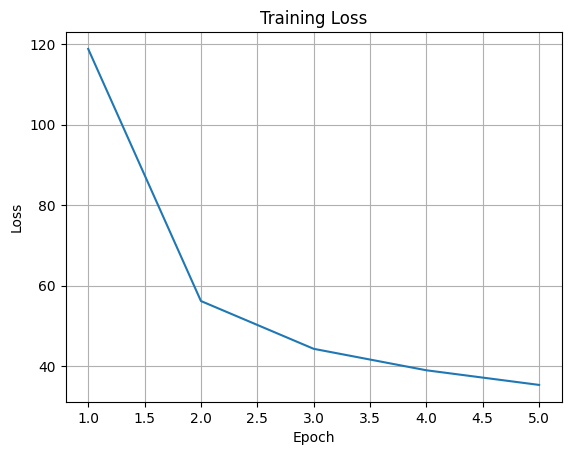

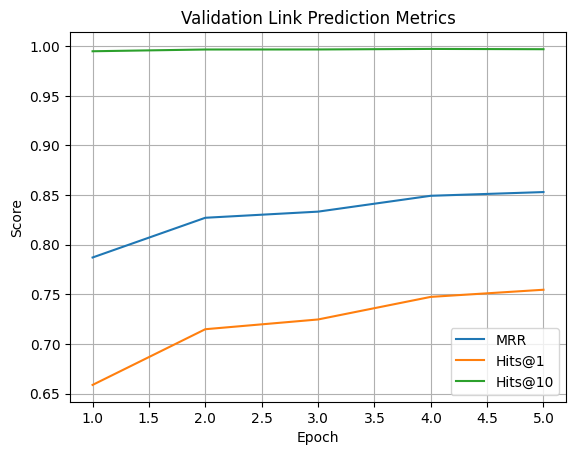

In [8]:
# @title
import numpy as np
import matplotlib.pyplot as plt

# ✅ Load training history
history = np.load("/content/Outputs/training_history.npy", allow_pickle=True).item()

epochs = history["epoch"]
loss   = history["loss"]
mrr    = history["mrr"]
h1     = history["h1"]
h10    = history["h10"]

# ---------------------------
# 📉 TRAINING LOSS
# ---------------------------
plt.figure()
plt.plot(epochs, loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.savefig("/content/Outputs/training_loss.png")
plt.show()

# ---------------------------
# 📊 LINK PREDICTION METRICS
# ---------------------------
plt.figure()
plt.plot(epochs, mrr, label="MRR")
plt.plot(epochs, h1,  label="Hits@1")
plt.plot(epochs, h10, label="Hits@10")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Link Prediction Metrics")
plt.legend()
plt.grid(True)
plt.savefig("/content/Outputs/link_prediction_metrics.png")
plt.show()


pos shape: (458474,)
neg shape: (458474, 30)
ROC-AUC: 0.9802607084372423


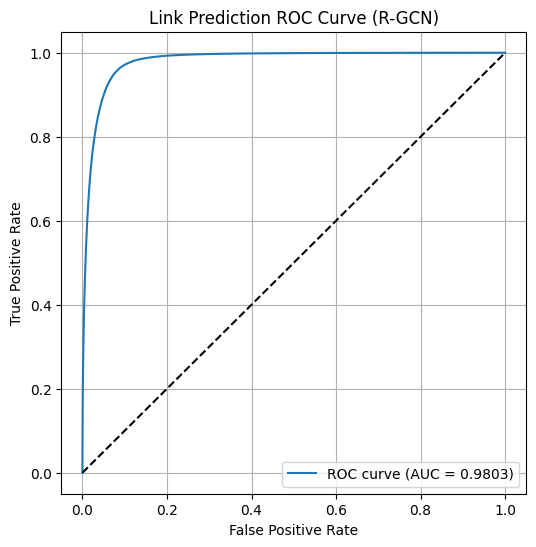

Precision@K: [(1, 0.8202362620344883), (5, 0.19865205006172654), (10, 0.09991689823196083), (20, 0.049994001840889535), (50, 0.03225806451612901)]


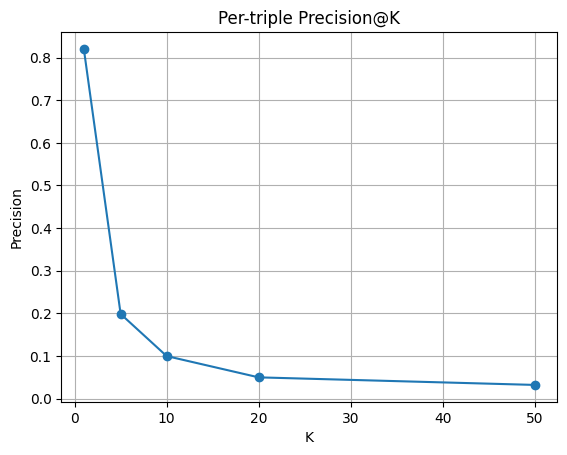

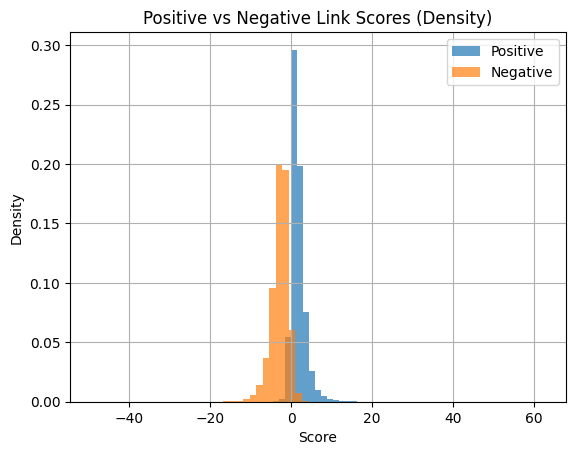

In [9]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# -------------------------------------------------
# 1) Load scores
# -------------------------------------------------
pos = np.load("/content/Outputs/pos_scores.npy")
neg = np.load("/content/Outputs/neg_scores.npy")

print("pos shape:", pos.shape)
print("neg shape:", neg.shape)

N, M = neg.shape

# -------------------------------------------------
# 2) ROC–AUC (global)
# -------------------------------------------------
pos_flat = pos.reshape(-1)
neg_flat = neg.reshape(-1)

scores = np.concatenate([pos_flat, neg_flat])
labels = np.concatenate([
    np.ones_like(pos_flat),
    np.zeros_like(neg_flat),
])

fpr, tpr, _ = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)
print("ROC-AUC:", roc_auc)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Link Prediction ROC Curve (R-GCN)")
plt.legend()
plt.grid(True)
plt.savefig("/content/Outputs/roc_curve_rgcn.png")
plt.show()

# -------------------------------------------------
# 3) Per-triple Precision@K
# -------------------------------------------------
def precision_at_k_per_triple(pos_scores, neg_scores, K):
    """
    pos_scores: (N,)
    neg_scores: (N, M)
    returns: scalar mean precision@K over N triples
    """
    N, M = neg_scores.shape
    K = min(K, M + 1)   # can't take more than 1 positive + M negatives

    precisions = []

    for i in range(N):
        scores_i = np.concatenate([[pos_scores[i]], neg_scores[i]])
        labels_i = np.concatenate([[1], np.zeros(M)])

        idx = np.argsort(scores_i)[::-1][:K]
        precisions.append(labels_i[idx].mean())

    return float(np.mean(precisions))

Ks = [1, 5, 10, 20, 50]
precisions = [precision_at_k_per_triple(pos, neg, k) for k in Ks]

print("Precision@K:", list(zip(Ks, precisions)))

plt.figure()
plt.plot(Ks, precisions, marker="o")
plt.xlabel("K")
plt.ylabel("Precision")
plt.title("Per-triple Precision@K")
plt.grid(True)
plt.savefig("/content/Outputs/precision_at_k_per_triple.png")
plt.show()

# -------------------------------------------------
# 4) Score distributions (density histograms)
# -------------------------------------------------
pos_all = pos_flat
neg_all = neg_flat

plt.figure()
plt.hist(pos_all, bins=50, alpha=0.7, label="Positive", density=True)
plt.hist(neg_all, bins=50, alpha=0.7, label="Negative", density=True)
plt.xlabel("Score")
plt.ylabel("Density")
plt.title("Positive vs Negative Link Scores (Density)")
plt.legend()
plt.grid(True)
plt.savefig("/content/Outputs/score_distribution_density.png")
plt.show()


In [10]:
# @title
import os
import numpy as np

import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

SAVE_DIR = "/content/Outputs/"
HISTORY_PATH = os.path.join(SAVE_DIR, "training_history.npy")

def safe_load_history(path):
    if not os.path.exists(path):
        print(f"❌ Missing: {path}")
        return None
    try:
        obj = np.load(path, allow_pickle=True).item()
        return obj if isinstance(obj, dict) else None
    except Exception as e:
        print("❌ Could not load history:", e)
        return None

def safe_plot(x, ys, labels, title, xlabel, ylabel, outname):
    try:
        x = list(x)
        if len(x) == 0:
            return
        plt.figure()
        ok = False
        for y, lab in zip(ys, labels):
            if y is None:
                continue
            if len(y) != len(x):
                continue
            plt.plot(x, y, label=lab)
            ok = True
        if not ok:
            plt.close()
            return
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if any(labels):
            plt.legend()
        plt.savefig(os.path.join(SAVE_DIR, outname), dpi=200, bbox_inches="tight")
        plt.close()
    except Exception:
        try: plt.close()
        except: pass

def load_scores(ep):
    p = os.path.join(SAVE_DIR, f"val_pos_scores_epoch_{ep:02d}.npy")
    n = os.path.join(SAVE_DIR, f"val_neg_scores_epoch_{ep:02d}.npy")
    if not (os.path.exists(p) and os.path.exists(n)):
        return None, None
    try:
        pos = np.asarray(np.load(p)).reshape(-1)
        neg = np.asarray(np.load(n)).reshape(-1)
        if pos.size == 0 or neg.size == 0:
            return None, None
        return pos, neg
    except Exception:
        return None, None

def manual_roc_curve(y_true, y_score, n_thresh=250):
    y_true = np.asarray(y_true).astype(np.int32)
    y_score = np.asarray(y_score).astype(np.float64)

    if y_true.size == 0:
        return None, None

    smin, smax = float(np.min(y_score)), float(np.max(y_score))
    if smin == smax:
        return np.array([0.0, 1.0]), np.array([0.0, 1.0])

    thresholds = np.linspace(smax, smin, n_thresh)
    P = max(1, int(np.sum(y_true == 1)))
    N = max(1, int(np.sum(y_true == 0)))

    tpr, fpr = [], []
    for thr in thresholds:
        pred = (y_score >= thr).astype(np.int32)
        TP = int(np.sum((pred == 1) & (y_true == 1)))
        FP = int(np.sum((pred == 1) & (y_true == 0)))
        tpr.append(TP / P)
        fpr.append(FP / N)

    return np.array(fpr), np.array(tpr)

def manual_auc(fpr, tpr):
    if fpr is None or tpr is None or len(fpr) < 2:
        return None
    idx = np.argsort(fpr)
    return float(np.trapz(tpr[idx], fpr[idx]))

def plot_scores_and_roc(pos, neg, ep):
    # Histogram
    try:
        plt.figure()
        plt.hist(pos, bins=60, alpha=0.6, label="Positive")
        plt.hist(neg, bins=60, alpha=0.6, label="Negative")
        plt.title(f"Link Score Distribution (Equal Pos vs Neg) - Epoch {ep:02d}")
        plt.xlabel("Link Score")
        plt.ylabel("Count")
        plt.legend()
        plt.savefig(os.path.join(SAVE_DIR, f"plot_score_dist_epoch_{ep:02d}.png"), dpi=200, bbox_inches="tight")
        plt.close()
    except Exception:
        try: plt.close()
        except: pass

    # ROC curve (manual)
    try:
        y_true = np.concatenate([np.ones_like(pos), np.zeros_like(neg)])
        y_score = np.concatenate([pos, neg])

        fpr, tpr = manual_roc_curve(y_true, y_score)
        auc = manual_auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr)
        title = f"ROC Curve (Equal Pos vs Neg) - Epoch {ep:02d}"
        if auc is not None:
            title += f" | AUC={auc:.4f}"
        plt.title(title)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.savefig(os.path.join(SAVE_DIR, f"plot_roc_curve_epoch_{ep:02d}.png"), dpi=200, bbox_inches="tight")
        plt.close()
    except Exception:
        try: plt.close()
        except: pass

def main():
    hist = safe_load_history(HISTORY_PATH)
    if hist is None:
        print("❌ No history to plot.")
        return

    epochs = hist.get("epoch", [])
    if epochs is None or len(epochs) == 0:
        print("❌ history has no epochs.")
        return

    epochs = [int(e) for e in epochs]

    # Loss
    safe_plot(epochs, [hist.get("loss_avg")], ["Loss(avg)"], "Training Loss", "Epoch", "Loss", "plot_training_loss.png")

    # Ranking
    safe_plot(
        epochs,
        [hist.get("mrr"), hist.get("h1"), hist.get("h10")],
        ["MRR", "Hits@1", "Hits@10"],
        "Validation Ranking Metrics (GLOBAL negatives)",
        "Epoch",
        "Score",
        "plot_val_ranking.png"
    )

    # ROC-AUC curve over epochs (stored as nan if sklearn missing)
    auc_vals = hist.get("auc", None)
    if auc_vals is not None and len(auc_vals) == len(epochs):
        safe_plot(epochs, [auc_vals], ["ROC-AUC"], "Validation ROC-AUC (GLOBAL 1:1)", "Epoch", "ROC-AUC", "plot_val_roc_auc.png")

    # Precision@K
    pk_keys = sorted([k for k in hist.keys() if isinstance(k, str) and k.startswith("p@")],
                     key=lambda s: int(s.split("@")[1]) if "@" in s else 10**9)
    if len(pk_keys) > 0:
        safe_plot(
            epochs,
            [hist.get(k) for k in pk_keys],
            [k.upper() for k in pk_keys],
            "Validation Precision@K (GLOBAL candidate sets)",
            "Epoch",
            "Precision",
            "plot_val_precision_at_k.png"
        )

    # Score dist + ROC for last available epoch
    last_available = None
    for ep in reversed(epochs):
        pos, neg = load_scores(ep)
        if pos is not None and neg is not None:
            plot_scores_and_roc(pos, neg, ep)
            last_available = ep
            break

    print("✅ Plots saved in /content")
    if last_available is not None:
        print(f"✅ Score/ROC plots generated for epoch {last_available:02d}")

if __name__ == "__main__":
    main()


✅ Plots saved in /content


In [12]:
# @title
import numpy as np
import matplotlib.pyplot as plt

history = np.load("/content/Outputs/training_history.npy", allow_pickle=True).item()

epochs = history["epoch"]
loss   = history["loss"]
mrr    = history["mrr"]
h1     = history["h1"]
h10    = history["h10"]

# ---------------------------
# 📉 TRAINING LOSS
# ---------------------------
plt.figure(figsize=(8,5))
plt.plot(epochs, loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# ---------------------------
# 📊 LINK PREDICTION METRICS
# ---------------------------
plt.figure(figsize=(10,6))
plt.plot(epochs, mrr, label="MRR")
plt.plot(epochs, h1,  label="Hits@1")
plt.plot(epochs, h10, label="Hits@10")
plt.title("Validation Link Prediction Metrics")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


**PURE RCGN**

With


*   BATCH_SIZE = 4096
*   Max edges = 600_000
*   NUM_NEIGHBORS = 10

In [1]:
%%writefile model_components.py

import random
from collections import defaultdict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# ============================================================
#              GAP-1: Dynamic-capacity Embedder (SAFE)
# ============================================================
class DynamicEmbedder(nn.Module):
    def __init__(self, num_nodes, high_nodes, low_nodes,
                 emb_dim_high, emb_dim_low, emb_dim_common):
        super().__init__()
        self.num_nodes = num_nodes
        self.emb_dim_common = emb_dim_common

        self.register_buffer("high_nodes", high_nodes.long())
        self.register_buffer("low_nodes", low_nodes.long())

        self.id_map_high = {int(n): i for i, n in enumerate(self.high_nodes.tolist())}
        self.id_map_low  = {int(n): i for i, n in enumerate(self.low_nodes.tolist())}

        self.emb_high = nn.Embedding(len(self.high_nodes), emb_dim_high)
        self.emb_low  = nn.Embedding(len(self.low_nodes),  emb_dim_low)

        self.proj_high = nn.Linear(emb_dim_high, emb_dim_common)
        self.proj_low  = nn.Linear(emb_dim_low,  emb_dim_common)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.emb_high.weight)
        nn.init.xavier_uniform_(self.emb_low.weight)
        nn.init.xavier_uniform_(self.proj_high.weight)
        nn.init.xavier_uniform_(self.proj_low.weight)
        nn.init.zeros_(self.proj_high.bias)
        nn.init.zeros_(self.proj_low.bias)

    def forward(self, node_ids):
      DEVICE = node_ids.device
      node_ids_cpu = node_ids.cpu()
      out = torch.zeros(
        node_ids.size(0),
        self.emb_dim_common,
        device=DEVICE,
        dtype=torch.float32
      )
      high_mask = torch.isin(node_ids_cpu, self.high_nodes.cpu())
      low_mask = ~high_mask

      if high_mask.any():
        high_nodes = node_ids_cpu[high_mask]
        high_idx = torch.tensor(
            [self.id_map_high[int(i)] for i in high_nodes],
            device=DEVICE
        )
        high_emb = self.proj_high(self.emb_high(high_idx))

        # ✅ FORCE dtype match before index_put
        out[high_mask] = high_emb.to(out.dtype)
      if low_mask.any():
        low_nodes = node_ids_cpu[low_mask]
        low_idx = torch.tensor(
            [self.id_map_low.get(int(i), 0) for i in low_nodes],
            device=DEVICE
        )

        low_emb = self.proj_low(self.emb_low(low_idx))

        # ✅ FORCE dtype match before index_put
        out[low_mask] = low_emb.to(out.dtype)
      return out



# ============================================================
#                    SAFE R-GCN Layer (OOM-FREE)
# ============================================================
class RGCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim, num_relations):
        super().__init__()
        self.num_relations = num_relations
        self.W_r = nn.Parameter(torch.empty(num_relations, in_dim, out_dim))
        self.W_0 = nn.Linear(in_dim, out_dim)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.W_r)
        nn.init.xavier_uniform_(self.W_0.weight)
        nn.init.zeros_(self.W_0.bias)

    # ✅ Memory-safe relation-wise message passing
    def forward(self, x, edge_index, edge_type, num_nodes_local):
        DEVICE = x.device
        src = edge_index[0]
        dst = edge_index[1]

        out = torch.zeros(
            num_nodes_local,
            self.W_0.out_features,
            device=DEVICE,
            dtype=x.dtype   # ✅ CRITICAL AMP FIX
        )


        deg = torch.zeros(num_nodes_local, device=DEVICE, dtype=x.dtype)
        deg.index_add_(0, dst, torch.ones_like(dst, dtype=x.dtype))

        for r in range(self.num_relations):
            mask = (edge_type == r)
            if mask.sum() == 0:
                continue

            s = src[mask]
            d = dst[mask]

            msg = x[s] @ self.W_r[r]
            msg = msg / deg[d].clamp_min(1).unsqueeze(1)
            out.index_add_(0, d, msg)

        return out + self.W_0(x)


# ============================================================
#                    Full R-GCN (GAP-1 + GAP-2)
# ============================================================
class PureRGCN(nn.Module):
    def __init__(self, num_nodes, num_relations,
                 high_nodes, low_nodes,
                 emb_dim_high, emb_dim_low, emb_dim_common,
                 hidden_dim, num_layers, dropout):
        super().__init__()

        self.embedder = DynamicEmbedder(
            num_nodes, high_nodes, low_nodes,
            emb_dim_high, emb_dim_low, emb_dim_common
        )

        self.layers = nn.ModuleList()
        in_dim = emb_dim_common

        for i in range(num_layers):
            out = hidden_dim if i < num_layers - 1 else emb_dim_common
            self.layers.append(RGCNLayer(in_dim, out, num_relations))
            in_dim = out

        self.dropout = nn.Dropout(dropout)
        self.rel_embed = nn.Embedding(num_relations, emb_dim_common)

    # ✅ ✅ ✅ THIS IS THE ONLY CORRECT FORWARD
    def forward(self, local_nodes, edge_index_local, edge_type_local):
        x = self.embedder(local_nodes)

        for i, layer in enumerate(self.layers):
            x = layer(
                x,
                edge_index_local,
                edge_type_local,
                local_nodes.numel()   # ✅ required argument
            )

            if i < len(self.layers) - 1:
                x = F.relu(x)
                x = self.dropout(x)

        return x

    def score(self, h_global, r, t_global, local_nodes, local_emb):
        DEVICE = local_nodes.device
        lut = {int(g): i for i, g in enumerate(local_nodes.tolist())}

        h = local_emb[
            torch.tensor([lut[int(i)] for i in h_global.tolist()], device=DEVICE)
        ]
        t = local_emb[
            torch.tensor([lut[int(i)] for i in t_global.tolist()], device=DEVICE)
        ]

        rvec = self.rel_embed(r)
        return torch.sum(h * rvec * t, dim=-1)


# ============================================================
#                      Degree Split (GAP-1)
# ============================================================
def compute_degree(num_nodes, edge_index):
    deg = torch.zeros(num_nodes, dtype=torch.long)
    deg.index_add_(0, edge_index[0].cpu(), torch.ones(edge_index.size(1), dtype=torch.long))
    deg.index_add_(0, edge_index[1].cpu(), torch.ones(edge_index.size(1), dtype=torch.long))
    return deg

def degree_split(num_nodes, edge_index, pct):
    deg = compute_degree(num_nodes, edge_index)
    thresh = int(np.percentile(deg.numpy(), pct * 100))
    high = (deg >= thresh).nonzero(as_tuple=False).view(-1)
    low  = (deg <  thresh).nonzero(as_tuple=False).view(-1)
    return high, low


# ============================================================
#                Adjacency for Neighbor Sampling (GAP-2)
# ============================================================
def build_adj(num_nodes, edge_index, edge_type, num_relations):
    edge_index = edge_index.cpu()
    edge_type  = edge_type.cpu()

    out_neighbors = [defaultdict(list) for _ in range(num_relations)]

    for s, d, r in zip(
        edge_index[0].tolist(),
        edge_index[1].tolist(),
        edge_type.tolist()
    ):
        out_neighbors[r][s].append(d)

    return out_neighbors


# ============================================================
#                 Pure Python Neighbor Sampler (SAFE)
# ============================================================
def sample_subgraph(seeds, num_layers, num_neighbors,
                    node_adj, num_relations, max_edges):

    # Convert seeds to Python ints
    frontier = set(int(s) for s in seeds.tolist())
    nodes = set(frontier)

    # -----------------------
    # LAYER-WISE EXPANSION
    # -----------------------
    for _ in range(num_layers):

        new_frontier = set()

        for u in list(frontier):

            # If node has no neighbors
            if u not in node_adj:
                continue

            nbrs = node_adj[u]  # list of (relation, dst)

            # Sample neighbors
            if len(nbrs) <= num_neighbors:
                chosen = nbrs
            else:
                chosen = random.sample(nbrs, num_neighbors)

            for r, v in chosen:
                if v not in nodes:
                    nodes.add(v)
                    new_frontier.add(v)

        frontier = new_frontier

        # Hard cap to avoid huge subgraphs
        if len(nodes) * num_neighbors * num_layers > 2 * max_edges:
            break

    # -----------------------
    # BUILD LOCAL GRAPH
    # -----------------------
    local_nodes = sorted(nodes)
    lut = {g: i for i, g in enumerate(local_nodes)}

    ls, ld, lr = [], [], []
    edge_count = 0

    for u in local_nodes:

        if u not in node_adj:
            continue

        u_local = lut[u]

        for r, v in node_adj[u]:
            if v in nodes:
                ls.append(u_local)
                ld.append(lut[v])
                lr.append(r)
                edge_count += 1

                if edge_count >= max_edges:
                    break

    DEVICE = seeds.device

    edge_index_local = torch.tensor([ls, ld], dtype=torch.long, device=DEVICE)
    edge_type_local  = torch.tensor(lr, dtype=torch.long, device=DEVICE)
    local_nodes      = torch.tensor(local_nodes, dtype=torch.long, device=DEVICE)

    return local_nodes, edge_index_local, edge_type_local


# ============================================================
#         Negative Sampling (training utility)
# ============================================================
def sample_pos_neg(edge_index, edge_type, idx, num_nodes, negative_ratio):
    pos_edges = edge_index[:, idx]
    pos_r = edge_type[idx]
    B = pos_edges.size(1)

    neg_t = torch.randint(0, num_nodes, (B * negative_ratio,), device=edge_index.device)
    neg_h = pos_edges[0].repeat(negative_ratio)
    neg_r = pos_r.repeat(negative_ratio)

    return pos_edges[0], pos_r, pos_edges[1], neg_h, neg_r, neg_t


Writing model_components.py


In [2]:
%%writefile train_rgcn.py
import os
import torch
import numpy as np
from torch.amp import autocast, GradScaler


from model_components import (
    PureRGCN,
    degree_split,
    sample_pos_neg,
    sample_subgraph,
)

# -------------------------------
# Kaggle PATHS
# -------------------------------
GRAPH_DATA = "graph_data.pt"
NODE_ADJ_PATH = "node_adj.pt"   # ✅ FAST node-centric adjacency

SAVE_DIR = "/content/Outputs/"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

EMB_DIM_HIGH = 512
EMB_DIM_LOW  = 128
EMB_DIM_COMMON = 256

HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.2

NUM_NEIGHBORS = 10
HIGH_DEG_PCT = 0.80
MAX_EDGES = 600_000

LR = 1e-3
EPOCHS = 5
BATCH_SIZE = 4096
NEGATIVE_RATIO = 1

# -------------------------------
# RANKING VALIDATION (MRR / HITS) + SAVE POS/NEG SCORES (KAGGLE)
# -------------------------------
@torch.no_grad()
def eval_batched(model, edge_index, edge_type, val_idx, node_adj, num_rel):
    model.eval()

    SAVE_DIR_EVAL = "/content/Outputs/"
    os.makedirs(SAVE_DIR_EVAL, exist_ok=True)

    all_pos_scores = []
    all_neg_scores = []

    rr = hits1 = hits10 = 0
    total = 0

    step = 1024          # batch size for validation
    k_neg = 50           # number of negatives used for ranking
    neg_save_k = 30      # number of negatives saved per triple (for histograms)

    for start in range(0, val_idx.numel(), step):
        sl = val_idx[start:start+step]

        pos_e = edge_index[:, sl]
        pos_r = edge_type[sl]

        # subgraph seeds from heads + tails
        seeds = torch.cat([pos_e[0], pos_e[1]]).unique()

        local_nodes, eidx, etype = sample_subgraph(
            seeds, NUM_LAYERS, NUM_NEIGHBORS,
            node_adj, num_rel, MAX_EDGES
        )

        # safety fallback
        if eidx.numel() == 0:
            local_nodes = seeds
            eidx  = torch.empty(2, 0, dtype=torch.long, device=DEVICE)
            etype = torch.empty(0, dtype=torch.long, device=DEVICE)

        local_emb = model(local_nodes, eidx, etype)

        # true score per triple (h,r,t)
        true_scores = model.score(pos_e[0], pos_r, pos_e[1], local_nodes, local_emb)  # (B,)

        # sample negatives from local nodes (fast)
        K = min(k_neg, local_nodes.numel())
        neg_idx = torch.randint(0, local_nodes.numel(), (true_scores.size(0), K), device=DEVICE)
        neg_tails = local_nodes[neg_idx]  # (B, K)

        neg_scores = []
        for i in range(true_scores.size(0)):
            hs = pos_e[0][i].repeat(K)
            rs = pos_r[i].repeat(K)
            ts = neg_tails[i]
            neg_scores.append(
                model.score(hs, rs, ts, local_nodes, local_emb).unsqueeze(0)
            )

        neg_scores = torch.cat(neg_scores, dim=0)  # (B, K)

        # ranks (sampled negatives)
        ranks = 1 + (neg_scores > true_scores.unsqueeze(1)).sum(1)

        rr += (1.0 / ranks.float()).sum().item()
        hits1 += (ranks <= 1).sum().item()
        hits10 += (ranks <= 10).sum().item()
        total += ranks.numel()

        # -------------------------------
        # SAVE SCORE DISTRIBUTIONS
        # -------------------------------
        all_pos_scores.append(true_scores.detach().float().cpu())  # (B,)

        kk = min(neg_save_k, neg_scores.size(1))
        all_neg_scores.append(neg_scores[:, :kk].detach().float().cpu())  # (B, kk)

    # concat + save
    pos_arr = torch.cat(all_pos_scores, dim=0).numpy()     # (N,)
    neg_arr = torch.cat(all_neg_scores, dim=0).numpy()     # (N, kk)

    np.save(f"{SAVE_DIR_EVAL}pos_scores.npy", pos_arr)
    np.save(f"{SAVE_DIR_EVAL}neg_scores.npy", neg_arr)

    return {"MRR": rr/total, "H@1": hits1/total, "H@10": hits10/total}




# -------------------------------
# MAIN TRAINING LOOP
# -------------------------------
def main():

    print("Loading:", GRAPH_DATA)
    data = torch.load(GRAPH_DATA, map_location=DEVICE)

    num_nodes = int(data["num_nodes"])
    num_rel   = int(data["num_relations"])

    edge_index = data["edge_index"].to(DEVICE)
    edge_type  = data["edge_type"].to(DEVICE)

    train_idx = data["train_idx"].to(DEVICE)
    val_idx   = data["val_idx"].to(DEVICE)

    # -------------------------------
    # GAP-1: DEGREE SPLIT
    # -------------------------------
    high, low = degree_split(num_nodes, edge_index, HIGH_DEG_PCT)
    print(f"High-degree: {high.numel()} | Low-degree: {low.numel()}")

    # -------------------------------
    # GAP-2: FAST NODE-CENTRIC ADJ
    # -------------------------------
    print("⚡ Loading node-centric adjacency...")
    node_adj = torch.load(NODE_ADJ_PATH, map_location="cpu")
    print("✅ Node adjacency loaded instantly.")

    # -------------------------------
    # MODEL
    # -------------------------------
    model = PureRGCN(
        num_nodes, num_rel,
        high.to(DEVICE), low.to(DEVICE),
        EMB_DIM_HIGH, EMB_DIM_LOW, EMB_DIM_COMMON,
        HIDDEN_DIM, NUM_LAYERS, DROPOUT
    ).to(DEVICE)

    opt = torch.optim.Adam(model.parameters(), lr=LR)
    scaler = GradScaler("cuda")


    history = {"epoch": [], "loss": [], "mrr": [], "h1": [], "h10": []}

    # -------------------------------
    # TRAINING
    # -------------------------------
    for ep in range(1, EPOCHS + 1):

        model.train()
        total_loss = 0
        perm = torch.randperm(train_idx.numel(), device=DEVICE)

        for start in range(0, perm.numel(), BATCH_SIZE):

            batch = train_idx[perm[start:start+BATCH_SIZE]]

            if ep == 1 and start == 0:
                print("🚀 First batch started — fast node-adj sampling active...")

            pos_h, pos_r, pos_t, neg_h, neg_r, neg_t = sample_pos_neg(
                edge_index, edge_type, batch, num_nodes, NEGATIVE_RATIO
            )

            seeds = torch.cat([pos_h, pos_t, neg_h, neg_t]).unique()

            local_nodes, eidx, etype = sample_subgraph(
                seeds, NUM_LAYERS, NUM_NEIGHBORS,
                node_adj, num_rel, MAX_EDGES
            )

            if ep == 1 and start == 0:
                print(f"✅ First subgraph ready with {local_nodes.numel()} nodes and {eidx.size(1)} edges")

            if eidx.numel() == 0:
                local_nodes = seeds
                eidx  = torch.empty(2,0,dtype=torch.long,device=DEVICE)
                etype = torch.empty(0,dtype=torch.long,device=DEVICE)

            with autocast("cuda"):
                local_emb = model(local_nodes, eidx, etype)

                pos_score = model.score(pos_h, pos_r, pos_t, local_nodes, local_emb)
                neg_score = model.score(neg_h, neg_r, neg_t, local_nodes, local_emb)

                loss = torch.nn.functional.margin_ranking_loss(
                    pos_score, neg_score,
                    torch.ones_like(pos_score), margin=1.0
                )

            opt.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            if ep == 1 and start == 0:
                print("✅ First optimizer step completed. Training fully warmed up.")

            total_loss += loss.item()

        print(f"\nEpoch {ep:02d} | Loss={total_loss:.4f}")

        # -------------------------------
        # VALIDATION
        # -------------------------------
        val_metrics = eval_batched(model, edge_index, edge_type, val_idx, node_adj, num_rel)

        print(
            f"VAL → MRR={val_metrics['MRR']:.4f} | "
            f"H@1={val_metrics['H@1']:.4f} | "
            f"H@10={val_metrics['H@10']:.4f}"
        )

        history["epoch"].append(ep)
        history["loss"].append(total_loss)
        history["mrr"].append(val_metrics["MRR"])
        history["h1"].append(val_metrics["H@1"])
        history["h10"].append(val_metrics["H@10"])

        ckpt_path = f"{SAVE_DIR}/epoch_{ep:02d}.pt"
        torch.save(model.state_dict(), ckpt_path)
        print("Saved checkpoint:", ckpt_path)

    # -------------------------------
    # FINAL SAVE
    # -------------------------------
    final_path = f"{SAVE_DIR}/pure_rgcn_final.pt"
    torch.save(model.state_dict(), final_path)
    print("✅ Saved FINAL model:", final_path)

    np.save(f"{SAVE_DIR}/training_history.npy", history)
    print("✅ Saved training history.")

# -------------------------------
if __name__ == "__main__":
    main()


Writing train_rgcn.py


In [3]:
!python train_rgcn.py

Loading: graph_data.pt
High-degree: 88675 | Low-degree: 334944
⚡ Loading node-centric adjacency...
✅ Node adjacency loaded instantly.
🚀 First batch started — fast node-adj sampling active...
✅ First subgraph ready with 151880 nodes and 713222 edges
✅ First optimizer step completed. Training fully warmed up.

Epoch 01 | Loss=89.3879
VAL → MRR=0.7462 | H@1=0.6160 | H@10=0.9797
Saved checkpoint: /content/Outputs//epoch_01.pt

Epoch 02 | Loss=36.5716
VAL → MRR=0.7848 | H@1=0.6644 | H@10=0.9879
Saved checkpoint: /content/Outputs//epoch_02.pt

Epoch 03 | Loss=27.0063
VAL → MRR=0.8055 | H@1=0.6917 | H@10=0.9909
Saved checkpoint: /content/Outputs//epoch_03.pt

Epoch 04 | Loss=22.4568
VAL → MRR=0.8199 | H@1=0.7127 | H@10=0.9914
Saved checkpoint: /content/Outputs//epoch_04.pt

Epoch 05 | Loss=19.8023
VAL → MRR=0.8234 | H@1=0.7178 | H@10=0.9919
Saved checkpoint: /content/Outputs//epoch_05.pt
✅ Saved FINAL model: /content/Outputs//pure_rgcn_final.pt
✅ Saved training history.


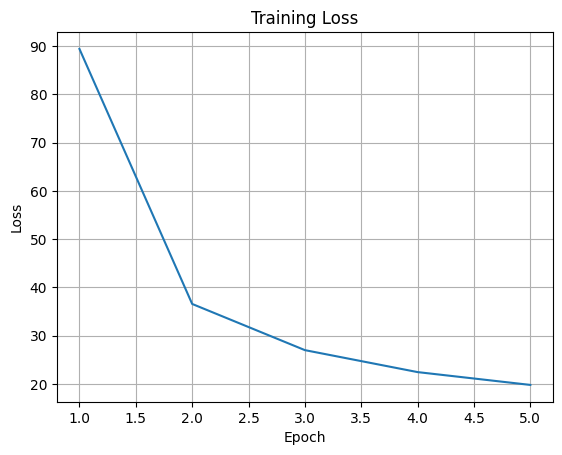

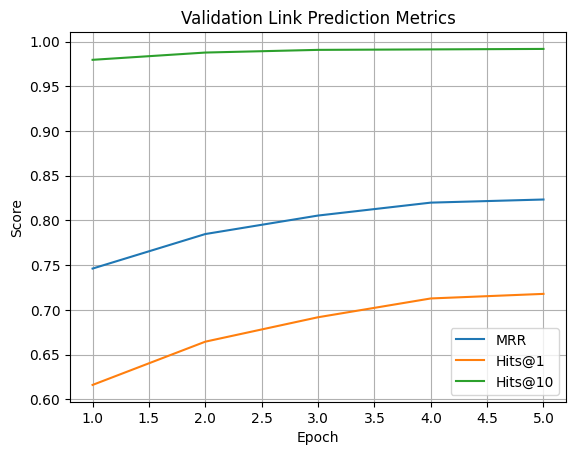

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ✅ Load training history
history = np.load("/content/Outputs/training_history.npy", allow_pickle=True).item()

epochs = history["epoch"]
loss   = history["loss"]
mrr    = history["mrr"]
h1     = history["h1"]
h10    = history["h10"]

# ---------------------------
# 📉 TRAINING LOSS
# ---------------------------
plt.figure()
plt.plot(epochs, loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.savefig("/content/Outputs/training_loss.png")
plt.show()

# ---------------------------
# 📊 LINK PREDICTION METRICS
# ---------------------------
plt.figure()
plt.plot(epochs, mrr, label="MRR")
plt.plot(epochs, h1,  label="Hits@1")
plt.plot(epochs, h10, label="Hits@10")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Link Prediction Metrics")
plt.legend()
plt.grid(True)
plt.savefig("/content/Outputs/link_prediction_metrics.png")
plt.show()


pos shape: (458474,)
neg shape: (458474, 30)
ROC-AUC: 0.9742344468883136


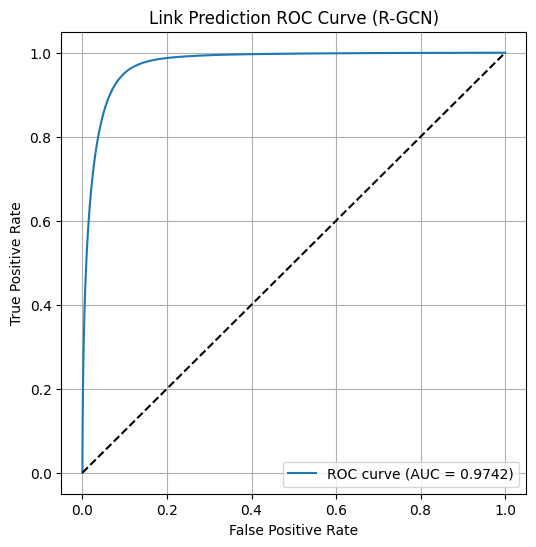

Precision@K: [(1, 0.7848449421341231), (5, 0.19689448038492924), (10, 0.09973869837766154), (20, 0.04997873379951755), (50, 0.03225806451612901)]


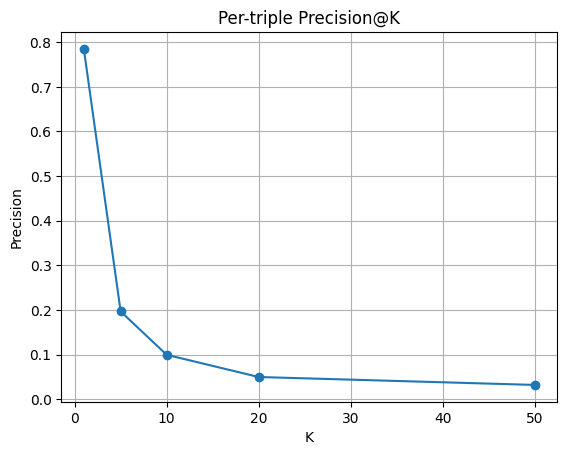

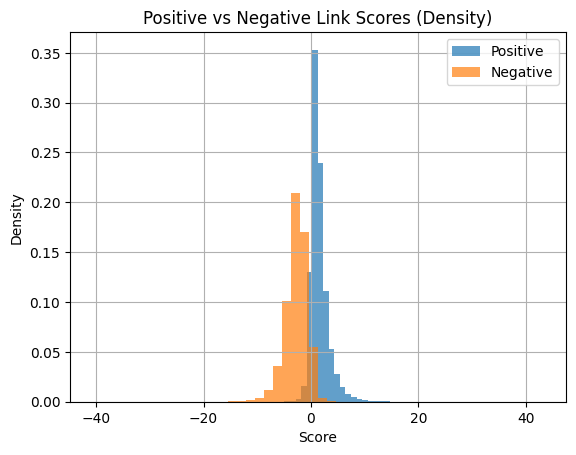

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# -------------------------------------------------
# 1) Load scores
# -------------------------------------------------
pos = np.load("/content/Outputs/pos_scores.npy")
neg = np.load("/content/Outputs/neg_scores.npy")

print("pos shape:", pos.shape)
print("neg shape:", neg.shape)

N, M = neg.shape

# -------------------------------------------------
# 2) ROC–AUC (global)
# -------------------------------------------------
pos_flat = pos.reshape(-1)
neg_flat = neg.reshape(-1)

scores = np.concatenate([pos_flat, neg_flat])
labels = np.concatenate([
    np.ones_like(pos_flat),
    np.zeros_like(neg_flat),
])

fpr, tpr, _ = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)
print("ROC-AUC:", roc_auc)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Link Prediction ROC Curve (R-GCN)")
plt.legend()
plt.grid(True)
plt.savefig("/content/Outputs/roc_curve_rgcn.png")
plt.show()

# -------------------------------------------------
# 3) Per-triple Precision@K
# -------------------------------------------------
def precision_at_k_per_triple(pos_scores, neg_scores, K):
    """
    pos_scores: (N,)
    neg_scores: (N, M)
    returns: scalar mean precision@K over N triples
    """
    N, M = neg_scores.shape
    K = min(K, M + 1)   # can't take more than 1 positive + M negatives

    precisions = []

    for i in range(N):
        scores_i = np.concatenate([[pos_scores[i]], neg_scores[i]])
        labels_i = np.concatenate([[1], np.zeros(M)])

        idx = np.argsort(scores_i)[::-1][:K]
        precisions.append(labels_i[idx].mean())

    return float(np.mean(precisions))

Ks = [1, 5, 10, 20, 50]
precisions = [precision_at_k_per_triple(pos, neg, k) for k in Ks]

print("Precision@K:", list(zip(Ks, precisions)))

plt.figure()
plt.plot(Ks, precisions, marker="o")
plt.xlabel("K")
plt.ylabel("Precision")
plt.title("Per-triple Precision@K")
plt.grid(True)
plt.savefig("/content/Outputs/precision_at_k_per_triple.png")
plt.show()

# -------------------------------------------------
# 4) Score distributions (density histograms)
# -------------------------------------------------
pos_all = pos_flat
neg_all = neg_flat

plt.figure()
plt.hist(pos_all, bins=50, alpha=0.7, label="Positive", density=True)
plt.hist(neg_all, bins=50, alpha=0.7, label="Negative", density=True)
plt.xlabel("Score")
plt.ylabel("Density")
plt.title("Positive vs Negative Link Scores (Density)")
plt.legend()
plt.grid(True)
plt.savefig("/content/Outputs/score_distribution_density.png")
plt.show()


In [6]:
from google.colab import files
files.download("/content/Outputs/pure_rgcn_final.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>